In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils
import matplotlib.pyplot as plt
import tensorflow as tf

#### Cropping the images to remove background

In [3]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img

#### Creating a cropped folder in which cropped training and testing images are stored

In [4]:
if __name__ == "__main__":
	training = "Dataset/Trainingbrain"
	testing = "Dataset/Testingbrain"
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256
	
	for dir in training_dir:
		save_path = 'Dataset/cropped/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)
	
	for dir in testing_dir:
		save_path = 'Dataset/cropped/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)


	

In [5]:
training_dir

['glioma', 'meningioma', 'notumor', 'pituitary']

#### Cropped images Demo 

In [6]:
img = cv2.imread('./Dataset/Trainingbrain/meningioma/Tr-me_0476.jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

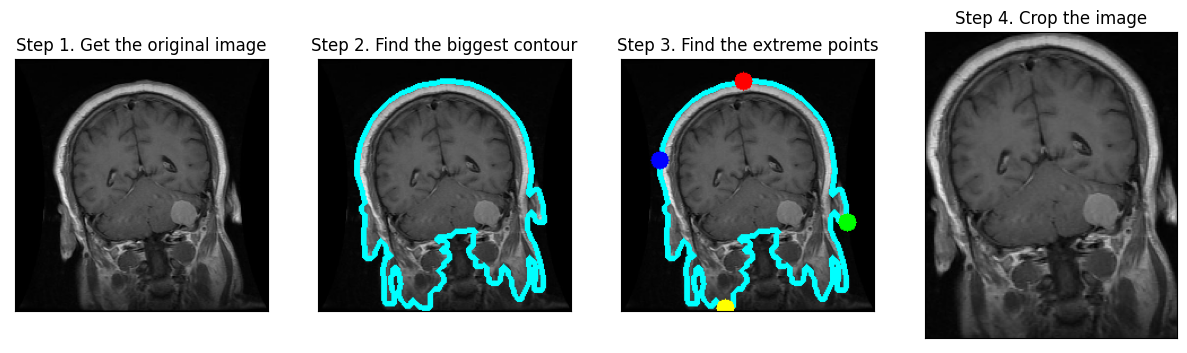

In [7]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [8]:
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 200
labels = ['glioma','meningioma','notumor','pituitary'] 
for i in labels:
    folderpath = os.path.join('./Dataset/Cropped/Training',i)
    for j in os.listdir(folderpath):
        image = cv2.imread(os.path.join(folderpath,j),0) #load images in gray
        image = cv2.bilateralFilter(image,2,50,50) # remove noise image
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images
        X_train.append(image)
        y_train.append(labels.index(i))
        
for i in labels:
    folderpath = os.path.join('./Dataset/Cropped/Testing',i)
    for j in os.listdir(folderpath):
        image = cv2.imread(os.path.join(folderpath,j),0) #load images in gray
        image = cv2.bilateralFilter(image,2,50,50) # remove noise image
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images
        X_test.append(image)
        y_test.append(labels.index(i))

X_train = np.array(X_train) / 255.0 # normalize Images into range 0 to 1.
X_test = np.array(X_test) / 255.0

print(X_train.shape)
print(X_test.shape)
        

(5712, 200, 200, 3)
(1311, 200, 200, 3)


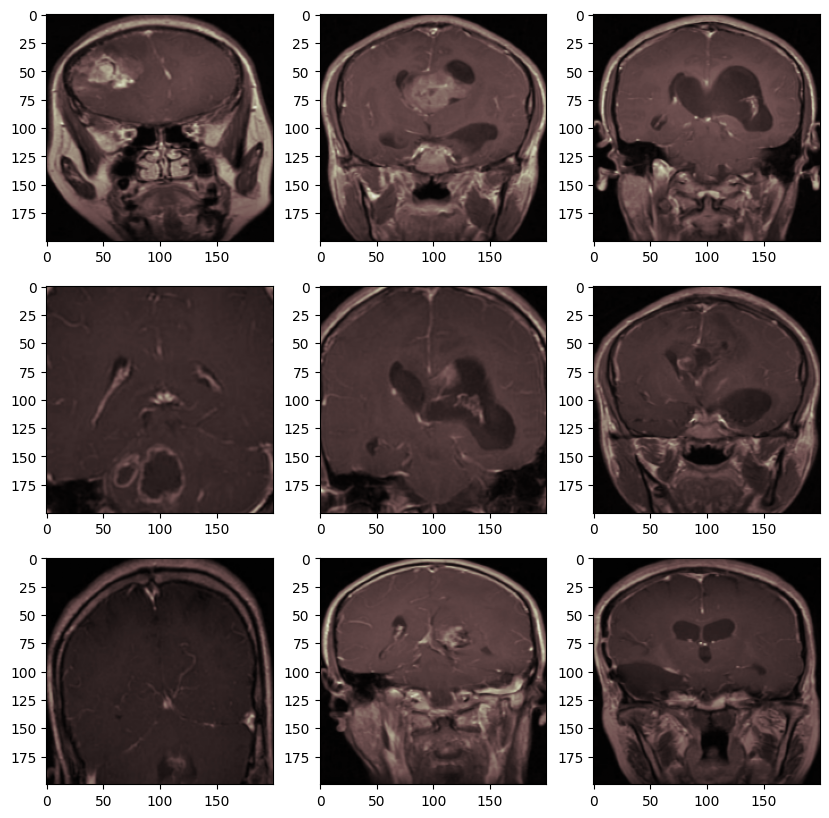

In [9]:
images = [X_train[i] for i in range(9)]
fig, axes = plt.subplots(3, 3, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
#plt.tight_layout()
plt.show()

In [10]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [11]:
X_train, y_train = shuffle(X_train,y_train, random_state=42) 

In [12]:
y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)

# 计算训练集中每个类别的数量
class_counts_train = np.sum(y_train, axis=0)

# 计算验证集中每个类别的数量
class_counts_val = np.sum(y_val, axis=0)

# 计算测试集中每个类别的数量
class_counts_test = np.sum(y_test, axis=0)

# 打印训练集中每个类别的数量
print("Training set class counts:")
print(class_counts_train)

# 打印验证集中每个类别的数量
print("\nValidation set class counts:")
print(class_counts_val)

# 打印测试集中每个类别的数量
print("\nTesting set class counts:")
print(class_counts_test)


(1143, 200, 200, 3)
(4569, 200, 200, 3)
(1311, 200, 200, 3)
Training set class counts:
[1060. 1072. 1279. 1158.]

Validation set class counts:
[261. 267. 316. 299.]

Testing set class counts:
[300. 306. 405. 300.]


#### Image Augmentation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam

In [15]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
     rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(X_train)

#### Model Training

In [16]:
from tensorflow.keras.applications.resnet import ResNet50
IMG_SIZE=(200,200)
base_model = ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet')

for layer in base_model.layers:
    layer.trainable = True

94781440/94765736 [==============================] - 15s 0us/step


In [17]:
from tensorflow.keras.applications.resnet import ResNet50
IMG_SIZE=(200,200)
base_model = ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet')

for layer in base_model.layers:
    layer.trainable = True

In [18]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [19]:
# Customized layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
predict = Dense(4,activation='softmax')(x)

# create a model object
model = Model(inputs = base_model.input,outputs = predict)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [20]:
#compile our model.
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

Optimizer Definition:
An instance of the Adam optimizer is defined here. Adam is a widely-used optimization algorithm in deep learning, known for its efficiency and computational effectiveness. It combines the benefits of both momentum and RMSProp, and adaptively adjusts the learning rate during training. By setting learning_rate=0.0001, a relatively small learning rate is specified, which can help the model converge more stably, albeit potentially requiring more epochs to reach optimal performance.

Model Compilation:
optimizer=adam: Specifies that the previously defined Adam optimizer should be used to perform backpropagation and weight updates during training.
loss='categorical_crossentropy': Chooses "categorical crossentropy" as the loss function. This is a commonly used loss function for multi-class classification problems, particularly when the output layer uses a softmax activation. Categorical crossentropy measures the difference between two probability distributions – in this case, the true distribution of labels versus the predicted probabilities by the model.

In [21]:
train_len = len(X_train)
val_len = len(X_val)
print("-----------Training Data length-----------------")
print(train_len)

print("-----------Validation Data length-----------------")
print(val_len)

-----------Training Data length-----------------
4569
-----------Validation Data length-----------------
1143


In [22]:
hist = model.fit(datagen.flow(X_train, y_train, batch_size=8),validation_data = (X_val,y_val),epochs = 25,verbose=1)

Epoch 1/25
572/572 [==============================] - 123s 186ms/step - loss: 0.3704 - accuracy: 0.8671 - val_loss: 3.1764 - val_accuracy: 0.2931
Epoch 2/25
572/572 [==============================] - 103s 179ms/step - loss: 0.1753 - accuracy: 0.9374 - val_loss: 0.2174 - val_accuracy: 0.9361
Epoch 3/25
572/572 [==============================] - 104s 182ms/step - loss: 0.1294 - accuracy: 0.9575 - val_loss: 0.4036 - val_accuracy: 0.8749
Epoch 4/25
572/572 [==============================] - 104s 182ms/step - loss: 0.1014 - accuracy: 0.9667 - val_loss: 0.1340 - val_accuracy: 0.9659
Epoch 5/25
572/572 [==============================] - 103s 180ms/step - loss: 0.0797 - accuracy: 0.9740 - val_loss: 0.0928 - val_accuracy: 0.9799
Epoch 6/25
572/572 [==============================] - 106s 184ms/step - loss: 0.0706 - accuracy: 0.9764 - val_loss: 0.4993 - val_accuracy: 0.8399
Epoch 7/25
572/572 [==============================] - 103s 180ms/step - loss: 0.0630 - accuracy: 0.9786 - val_loss: 0.1919 -

#### Plotting output results

In [23]:
#Plotting the results
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

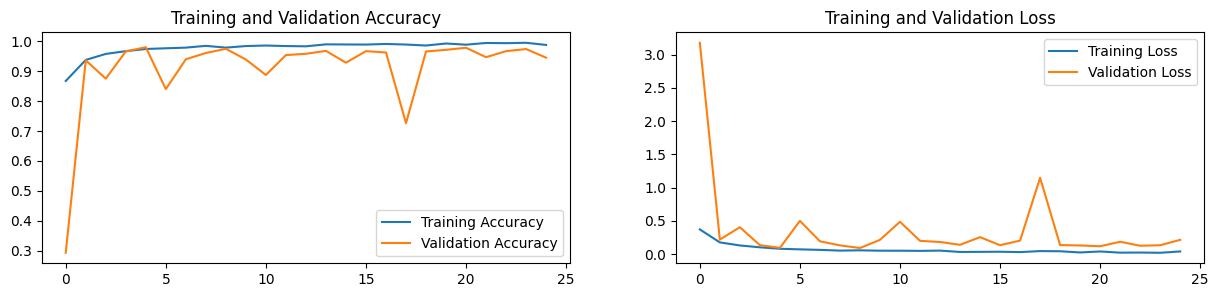

In [24]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend(loc= "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend(loc= "upper right")
plt.title("Training and Validation Loss")

In [25]:
#Saving the model
from keras.models import load_model
model.save('bestresnet4.h5')

#### Validation on Test set

In [28]:
import tensorflow as tf
with tf.device('/CPU:0'):
    loss, acc = model.evaluate(X_test, y_test)


41/41 [==============================] - 91s 2s/step - loss: 0.1855 - accuracy: 0.9458


In [27]:
loss,acc = model.evaluate(X_test,y_test)

ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv1_conv/Conv2D' defined at (most recent call last):
    File "C:\Users\dell\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\dell\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\dell\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\dell\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\dell\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 2975, in run_cell
      result = self._run_cell(
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3257, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\dell\AppData\Local\Temp/ipykernel_23696/2027149716.py", line 1, in <cell line: 1>
      hist = model.fit(datagen.flow(X_train, y_train, batch_size=8),validation_data = (X_val,y_val),epochs = 25,verbose=1)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\engine\training.py", line 1420, in fit
      val_logs = self.evaluate(
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\engine\training.py", line 1716, in evaluate
      tmp_logs = self.test_function(iterator)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\engine\training.py", line 1525, in test_function
      return step_function(self, iterator)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\engine\training.py", line 1514, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\engine\training.py", line 1507, in run_step
      outputs = model.test_step(data)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\engine\training.py", line 1471, in test_step
      y_pred = self(x, training=False)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\layers\convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "d:\BRAIN TUMOR PROJECT\project\myenv\lib\site-packages\keras\layers\convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv1_conv/Conv2D'
OOM when allocating tensor with shape[32,64,100,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv1_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_20530]

#### Classification Report

In [30]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
with tf.device('/CPU:0'):
    predicted_classes = np.argmax(model.predict(X_test), axis = 1)
    print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))

              precision    recall  f1-score   support

      glioma       0.95      0.94      0.94       300
  meningioma       0.94      0.91      0.92       306
    no_tumor       1.00      0.95      0.97       405
   pituitary       0.89      0.99      0.94       300

    accuracy                           0.95      1311
   macro avg       0.94      0.95      0.94      1311
weighted avg       0.95      0.95      0.95      1311



#### Confusion Matrix

328/328 [==============================] - 94s 286ms/step


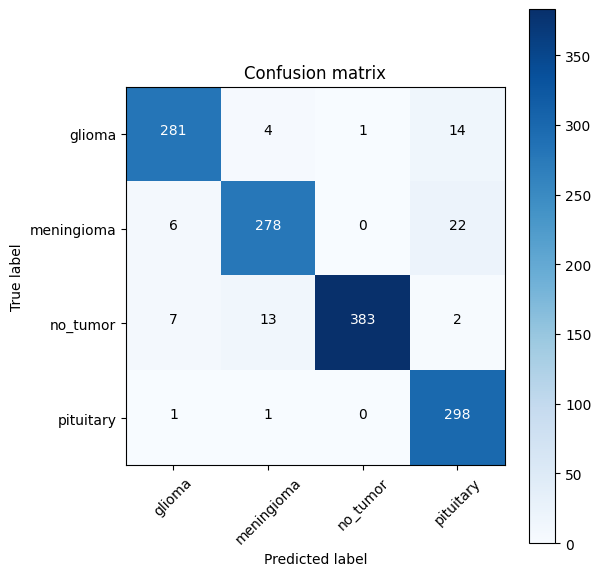

In [33]:
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure X_test is a NumPy array
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Use CPU to avoid GPU memory issues
with tf.device('/CPU:0'):
    pred_Y = model.predict(X_test, batch_size=4, verbose=True)

# Convert predictions to class labels
Y_pred_classes = np.argmax(pred_Y, axis=1)

# Convert true labels to class indices
rounded_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.0f}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Define class labels
target_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=target_names)


In [34]:
# import itertools
# with tf.device('/CPU:0'):
#     pred_Y = model.predict(X_test, batch_size=4, verbose=True)

# # pred_Y = model.predict(X_test, batch_size = 8, verbose = True)

# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     target_names=['glioma','meningioma','no_tumor','pituitary']

#     if target_names is not None:
#         tick_marks = np.arange(len(target_names))
#         plt.xticks(tick_marks, target_names, rotation=45)
#         plt.yticks(tick_marks, target_names)
    
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

# # Predict the values from the validation dataset
# Y_pred = model.predict(X_test, batch_size=8)
# # Convert predictions classes to one hot vectors 
# Y_pred_classes = np.argmax(pred_Y,axis = 1) 
# # Convert validation observations to one hot vectors
# # compute the confusion matrix
# rounded_labels=np.argmax(y_test, axis=1)
# confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

 

# # plot the confusion matrix
# plot_confusion_matrix(confusion_mtx, classes = range(4)) 

#### Plotting sample predictions

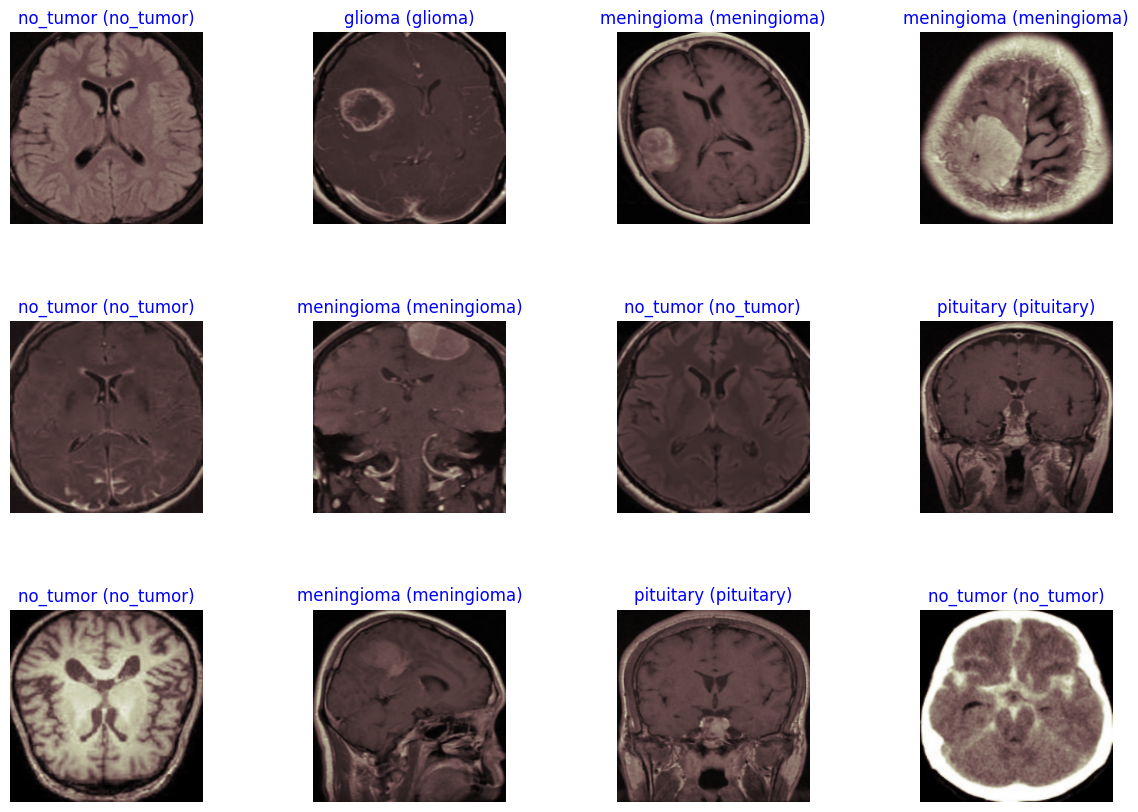

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure X_test is a NumPy array with correct data type
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Make predictions
with tf.device('/CPU:0'):  # Use CPU if GPU has memory issues
    y_hat = model.predict(X_test, batch_size=4)

# Define class labels
target_labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# Select random samples
num_samples = 12
random_indices = np.random.choice(X_test.shape[0], size=num_samples, replace=False)

# Plot test images with predictions
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

for ax, idx in zip(axes.ravel(), random_indices):
    image = X_test[idx]

    # If images are normalized (0 to 1), convert them back to 0-255
    if np.max(image) <= 1.0:
        image = (image * 255).astype(np.uint8)

    # If the image is grayscale, use cmap='gray'
    if image.ndim == 2 or image.shape[-1] == 1:
        ax.imshow(image.squeeze(), cmap='gray')
    else:
        ax.imshow(image)  # RGB image

    # Get predicted and actual labels
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])

    # Set title color: Blue if correct, Orange if incorrect
    ax.set_title(f"{target_labels[pred_idx]} ({target_labels[true_idx]})",
                 color=("blue" if pred_idx == true_idx else "orange"))

    ax.axis('off')  # Hide axes

plt.show()


In [39]:
# y_hat = model.predict(X_test)

# # define text labels 
# target_labels = ['glioma','meningioma','no_tumor','pituitary']

# # plot a random sample of test images, their predicted labels, and ground truth
# fig = plt.figure(figsize=(20, 8))
# for i, idx in enumerate(np.random.choice(X_test.shape[0], size=12, replace=False)):
#     ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
#     ax.imshow(np.squeeze(X_test[idx]))
#     pred_idx = np.argmax(y_hat[idx])
#     true_idx = np.argmax(y_test[idx])
#     ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
#                  color=("blue" if pred_idx == true_idx else "orange"))

In [40]:
from tensorflow.keras.models import load_model
model = load_model('bestresnet4.h5')

In [41]:
#Predicting a particiular image without image preprocessing
from tensorflow.keras.preprocessing import image
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor'] 
path ='.\Dataset\cropped\Testing\pituitary\Te-pi_0294.jpg'
img=image.load_img(path,target_size=(200,200))
x=image.img_to_array(img)
x=x/255
x=np.expand_dims(x,axis=0)
predict_image1 = model.predict(x)
indices1 = np.argmax(predict_image1,axis = 1)
print(labels[indices1[0]])


pituitary_tumor


In [43]:
import os
import time
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

# Define the labels
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Define the directories
directories = {
    'glioma': './Dataset/Testingbrain/glioma',
    'meningioma': './Dataset/Testingbrain/meningioma',
    'notumor': './Dataset/Testingbrain/notumor',
    'pituitary': './Dataset/Testingbrain/pituitary'
}

# Function to measure prediction time for images in a directory
def measure_prediction_time(model, directory):
    times = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = image.load_img(img_path, target_size=(200, 200))
        x = image.img_to_array(img)
        x = x / 255.0
        x = np.expand_dims(x, axis=0)
        
        start_time = time.time()
        predict_image = model.predict(x)
        end_time = time.time()
        
        prediction_time = end_time - start_time
        times.append(prediction_time)
    
    return times

# Dictionary to store times for each category
prediction_times = {}

# Measure prediction times for each category
for label, directory in directories.items():
    times = measure_prediction_time(model, directory)
    prediction_times[label] = times

# Create a DataFrame to organize the results
results = {
    'Category': [],
    'Average Time (s)': [],
    'Max Time (s)': [],
    'Min Time (s)': []
}

for label, times in prediction_times.items():
    avg_time = np.mean(times)
    max_time = np.max(times)
    min_time = np.min(times)
    results['Category'].append(label)
    results['Average Time (s)'].append(avg_time)
    results['Max Time (s)'].append(max_time)
    results['Min Time (s)'].append(min_time)

# Add overall statistics
overall_times = [time for times in prediction_times.values() for time in times]
avg_time = np.mean(overall_times)
max_time = np.max(overall_times)
min_time = np.min(overall_times)
results['Category'].append('Overall')
results['Average Time (s)'].append(avg_time)
results['Max Time (s)'].append(max_time)
results['Min Time (s)'].append(min_time)

# Create a DataFrame and print it
df = pd.DataFrame(results)
print(df)


     Category  Average Time (s)  Max Time (s)  Min Time (s)
0      glioma          0.051592      0.188901      0.031596
1  meningioma          0.052341      0.106483      0.032247
2     notumor          0.049880      0.316118      0.031886
3   pituitary          0.049570      0.068927      0.033417
4     Overall          0.050775      0.316118      0.031596
